In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,Conv2DTranspose,Input,BatchNormalization,LeakyReLU,Reshape,Dropout,Flatten
import tensorflow as tf
from tensorflow.keras.models import Sequential
import time

In [2]:

(train_images,_),(_,_)=tf.keras.datasets.mnist.load_data()
train_images=np.expand_dims(train_images,axis=-1)

In [3]:
train_images=(train_images.astype('float32')/127.5)-1
buffer_size=train_images.shape[0]
batch_size=256

In [4]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [5]:
def build_generator():
    model=Sequential()
    model.add(Input(shape=(100,)))
    model.add(Dense(7*7*256))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7,7,256)))
    model.add(Conv2DTranspose(128,(5,5),strides=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64,(5,5),strides=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',activation='tanh'))
    return model
generator=build_generator()
generator.summary()
    

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,266,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,343,681 (8.94 MB)

 Trainable params: 2,318,209 (8.84 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [6]:
def build_discriminator():
    model=Sequential()
    model.add(Input(shape=[28,28,1]))
    model.add(Conv2D(64,(5,5),strides=(2,2),padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))
    return model
discriminator=build_discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_optimizer=tf.keras.optimizers.Adam(1e-4)
disc_optimizer=tf.keras.optimizers.Adam(1e-4)

In [8]:
def discriminator_loss(real_output,fake_output):
    real_loss=loss_fn(tf.ones_like(real_output),real_output)
    fake_loss=loss_fn(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss
        

In [9]:
def generator_loss(fake_output):
    gen_loss=loss_fn(tf.ones_like(fake_output),fake_output)
    return gen_loss

In [10]:
def train_step(batch_size,images):
    noise=tf.random.normal([batch_size,100])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_images=generator(noise,training=True)
        real_output=discriminator(images,training=True)
        fake_output=discriminator(generated_images,training=True)
        disc_loss= discriminator_loss(real_output,fake_output)
        gen_loss=generator_loss(fake_output)
    disc_gradient=disc_tape.gradient(disc_loss,discriminator.trainable_weights)
    gen_gradient=gen_tape.gradient(gen_loss,generator.trainable_weights)
    gen_optimizer.apply_gradients(zip(gen_gradient,generator.trainable_weights))
    disc_optimizer.apply_gradients(zip(disc_gradient,discriminator.trainable_weights))

In [11]:
def train(epochs, batch_size, train_dataset):
    for epoch in range(epochs):
        start_time = time.time()
        print(f"Epoch {epoch} starting...")
        for i, image_batch in enumerate(train_dataset):
            if i % 10 == 0:
                print(f"Batch {i}")
            train_step(batch_size,image_batch)
        print(f"Time for epoch {epoch} is {time.time()-start_time:.2f} sec")


In [12]:
print(train_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [13]:
epochs=50
batch_size=256
train(epochs,batch_size,train_dataset)

Epoch 0 starting...
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Batch 120
Batch 130
Batch 140
Batch 150
Batch 160
Batch 170
Batch 180
Batch 190
Batch 200
Batch 210
Batch 220
Batch 230
Time for epoch 0 is 557.63 sec
Epoch 1 starting...
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Batch 120
Batch 130
Batch 140
Batch 150
Batch 160
Batch 170
Batch 180
Batch 190
Batch 200
Batch 210
Batch 220
Batch 230
Time for epoch 1 is 553.00 sec
Epoch 2 starting...
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Batch 120
Batch 130
Batch 140
Batch 150
Batch 160
Batch 170
Batch 180
Batch 190
Batch 200
Batch 210
Batch 220
Batch 230
Time for epoch 2 is 571.62 sec
Epoch 3 starting...
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Batch 120
Batch 130
Batch 140
B

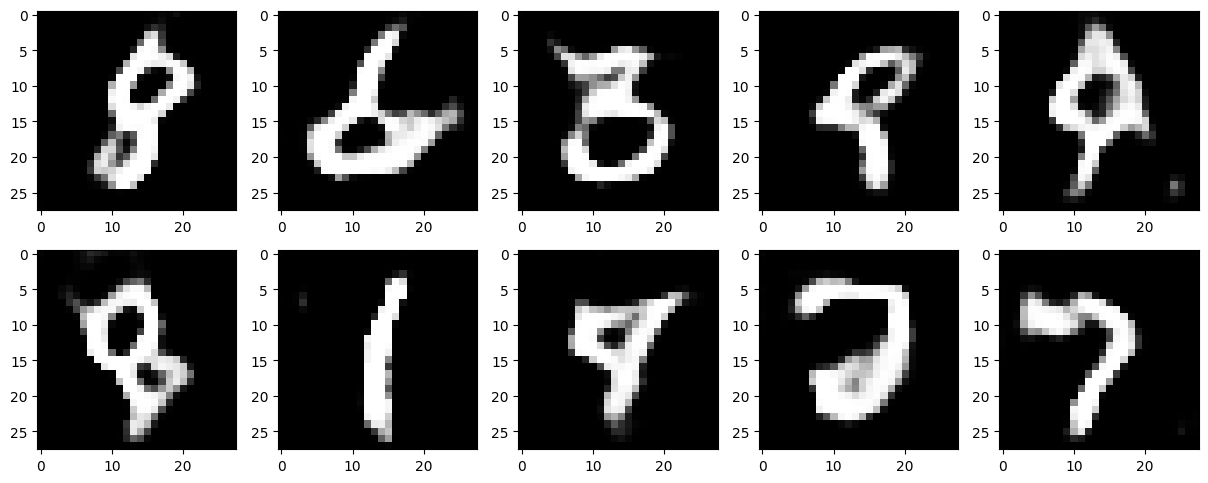

In [14]:
num_images = 10
noise = tf.random.normal([num_images,100])
generated_images = generator(noise)

plt.figure(figsize=(15, 15))
for i, image in enumerate(generated_images):
    image = (image + 1) / 2 
    plt.subplot(5, 5, i+1)  
    plt.imshow(image, cmap='gray')

plt.show()


In [15]:
from tensorflow.keras.models import save_model
generator=save_model('generator.keras')

TypeError: save_model() missing 1 required positional argument: 'filepath'